## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

import re

In [2]:
np.random.seed(42)

### Importing Data

For this notebook, I am only evaluating the Genres datasets (Fiction, Juvenile Fiction, and Biography & Autobiography). Each dataset has 50k rows, so I will be comparing their EDA results to one another.

In [6]:
fiction_df = pd.read_csv('./data/fiction_sample.csv')
fiction_df.head(2)

,Title,profileName,review/score,review/summary,review/text,description,authors,image,categories,ratingsCount
0,What Is the What,Gift Card Recipient,4.0,An inticing read,"What is the What shows the horrors in Sudan, l...",What Is the What is the story of Valentino Ach...,Dave Eggers,http://books.google.com/books/content?id=3HDpz...,Fiction,91.0
1,The Horde Wars: Ravenous (Book 1),"Shiloh Walker ""Shi""",5.0,"Hot action, hot heroes, amazing heroine..","Get ready for a fast, hot ride into a world we...",The Horde Wars - Ravenous By Sherri L King Boo...,Sherri L. King,http://books.google.com/books/content?id=-uADt...,Fiction,1.0


In [7]:
jvf_df = pd.read_csv('./data/jvf_sample.csv')
jvf_df.head(2)

,Title,profileName,review/score,review/summary,review/text,description,authors,image,categories,ratingsCount
0,The Princess Diaries,annajlane1989,5.0,The Princess Diaries,This book is great for teenage girls who norma...,"Fourteen-year-old Mia, who is trying to lead a...",Meg Cabot,http://books.google.com/books/content?id=hRHzn...,Juvenile Fiction,80.0
1,Night,"G. E. Kugler ""Ed Kugler - nomoreBS - Author o...",5.0,Important Book - A Must Read for Now and Forever,I've never been too much into studying the Hol...,Here is the wonderful new version of the class...,Clement Moore,http://books.google.com/books/content?id=LSSyD...,Juvenile Fiction,1.0


In [8]:
bio_df = pd.read_csv('./data/bio_sample.csv')
bio_df.head(2)

,Title,profileName,review/score,review/summary,review/text,description,authors,image,categories,ratingsCount
0,"Genghis Khan: Life, Death and Resurrection",P. Carey,2.0,Not a great book,Read both this book and Genghis Khan and the M...,"Genghis Khan is one of history's immortals, al...",John Man,http://books.google.com/books/content?id=0eEKA...,Biography & Autobiography,3.0
1,Queen Victoria,"Linda Baker ""quiltsbylin""",5.0,Masterful & a charming piece of true history,I went into this book after watching most of t...,Commemorating the centennial of Queen Victoria...,Christopher Hibbert,http://books.google.com/books/content?id=uWlnA...,Biography & Autobiography,5.0


### Unique Data

The datasets are rows of book reviews for a specific book. Thus, there could be authors that appear once or thousands of times. In the table, we see how many unique authors and books are represented in our datasets. The datasets could have bias, especially the Biography & Autobiography sample. There are only 2309 titles and 1946 authors represented in 50k rows. However, it could also benefit out model performances as they can better parse through the conditions to classify accurately.

In [9]:
unique_data = pd.DataFrame(columns = ['Titles', 'Authors'])
unique_data.loc['Fiction'] = [fiction_df['Title'].nunique(), fiction_df['authors'].nunique()]
unique_data.loc['Juvenile Fiction'] = [jvf_df['Title'].nunique(), jvf_df['authors'].nunique()]
unique_data.loc['Biography & Autobiography'] = [bio_df['Title'].nunique(), bio_df['authors'].nunique()]

In [10]:
unique_data

,Titles,Authors
Fiction,6722,3617
Juvenile Fiction,2874,1772
Biography & Autobiography,2309,1946


### Functions

* my_lemmatizer(text): This function lemmatizes inputted text to their dictionary forms. It adds conditions to filter out words with apostrophes or digits so they are done as accurately as possible.
* my_preprocessor(text): Custom function (from Lesson 5.05 NLP EDA) that matches text with contradictions and currency values.

In [11]:
def my_lemmatizer(text):
    wnet = WordNetLemmatizer()
    # exclude words with apostrophes and numbers
    return [wnet.lemmatize(w) for w in text.split() if "'" not in w and not w.isdigit()]

In [12]:
def my_preprocessor(text):
    text = text.lower()
    text = re.sub('\\n', '', text)
    text = re.findall("[\w']+|\$[\d\.]+", text)
    text = ' '.join(text)
    
    return text

### Comparison of Top N-Grams

Even with the my_preprocessor function, I was having issues where contractions were appearing in my graphs throughout my EDA. I created a list of lemmatized, English stopwords that will be used to remove the words that don't carry a significant meaning in my text. I also concatenated a list of contractions and numbers (hard-coded) to the lists as I deemed they didn't add value.

In [13]:
wnet = WordNetLemmatizer()
lem_stopwords = [wnet.lemmatize(w) for w in stopwords.words('english')]

contractions = ['ve', 't', "'s'", 'd', 'll', 'm', 're']
lem_contractions = [wnet.lemmatize(contraction) for contraction in contractions]

numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
lem_numbers = [wnet.lemmatize(num) for num in numbers]

lem_stopwords = lem_stopwords + lem_contractions + lem_numbers

To explore the bigrams and trigrams of the datasets, we convert the words in the text into tokens where the CountVectorizer will take the count of unique tokens. The conditions we add include removing our specific stopwords. While iterating, the CountVectorizer will generate bigrams and trigrams from the sequence of tokens.

The CountVectorizer uses the dataset's 'description' and 'review/text' values to accomplish this below. The bigrams and trigrams will give us insight on word patterns (e.g. which words occur together most often) along with the context about the text too. 

In [14]:
bigram_cvec = CountVectorizer(
    stop_words=lem_stopwords,
    tokenizer=my_lemmatizer,
    preprocessor=my_preprocessor,
    ngram_range = (2,2),
    max_features = 10_000,
    token_pattern = None
    )

In [15]:
trigram_cvec = CountVectorizer(
    stop_words=lem_stopwords,
    tokenizer=my_lemmatizer,
    preprocessor=my_preprocessor,
    ngram_range = (3,3),
    max_features = 10_000,
    token_pattern = None
    )

### Bigrams and Trigrams for Fiction Dataset

In [17]:
bigram_fic_desc = bigram_cvec.fit_transform(fiction_df['description'])
cv_bigram_fic_desc = pd.DataFrame(bigram_fic_desc.todense(), columns = bigram_cvec.get_feature_names_out())

trigram_fic_desc  = trigram_cvec.fit_transform(fiction_df['description'])
cv_trigram_fic_desc = pd.DataFrame(trigram_fic_desc.todense(), columns = trigram_cvec.get_feature_names_out())

In [18]:
bigram_fic_rev = bigram_cvec.fit_transform(fiction_df['review/text'])
cv_bigram_fic_rev = pd.DataFrame(bigram_fic_rev.todense(), columns = bigram_cvec.get_feature_names_out())

trigram_fic_rev  = trigram_cvec.fit_transform(fiction_df['review/text'])
cv_trigram_fic_rev = pd.DataFrame(trigram_fic_rev.todense(), columns = trigram_cvec.get_feature_names_out())

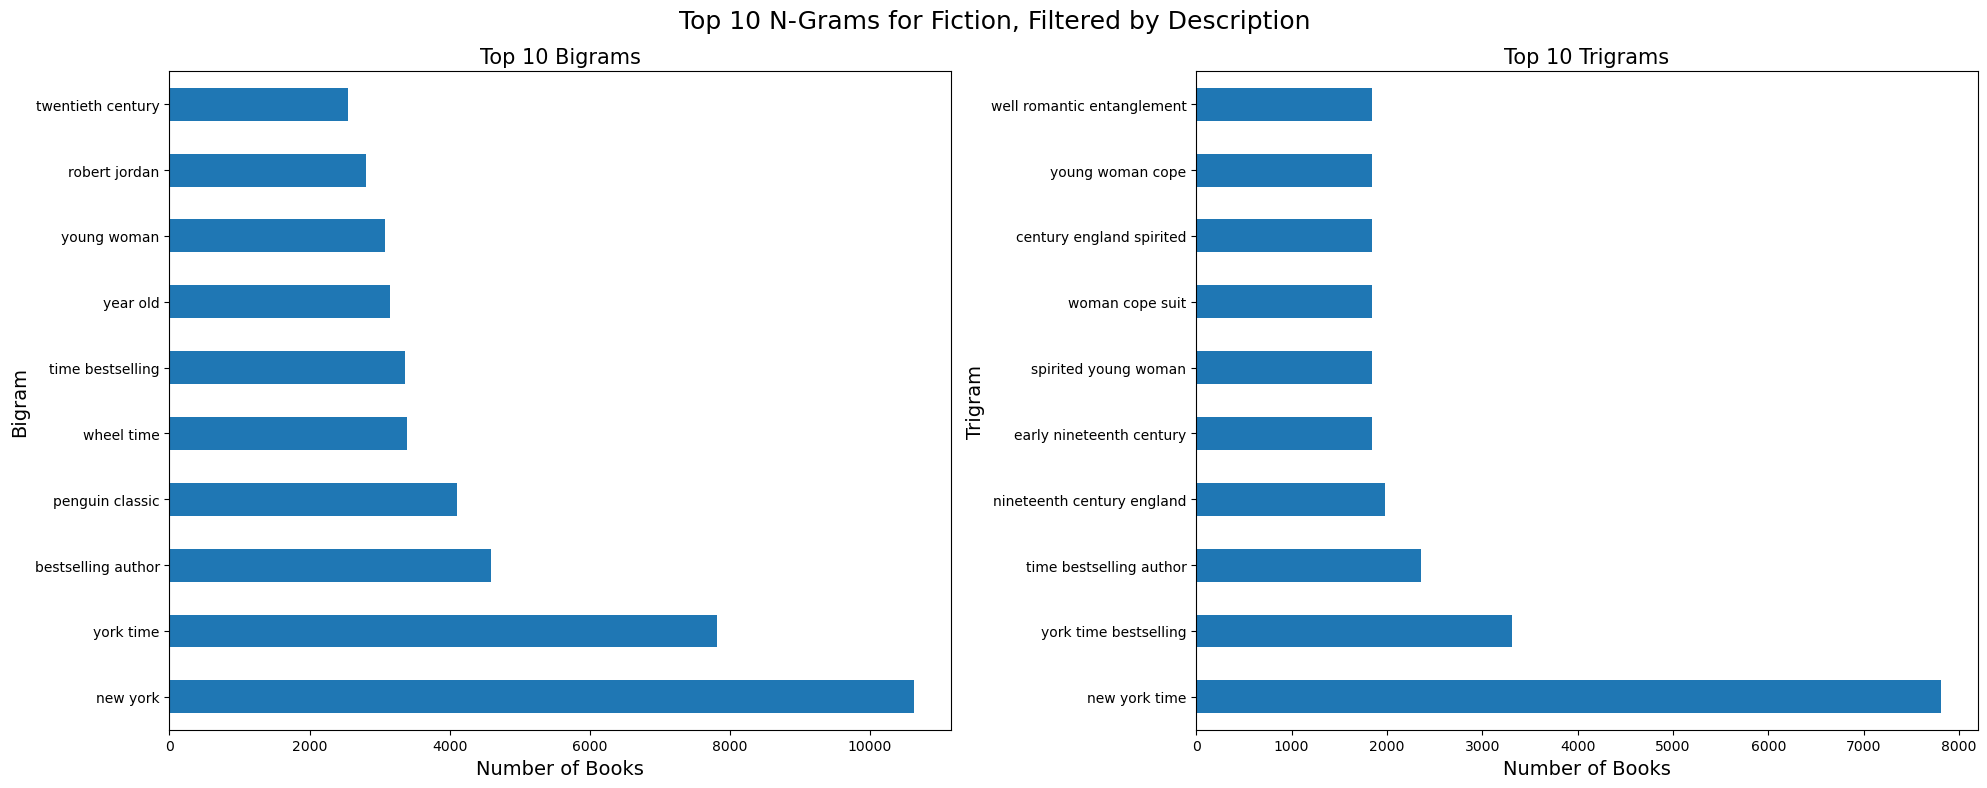

In [19]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
fig.suptitle('Top 10 N-Grams for Fiction, Filtered by Description', fontsize = 18)

fic_desc_bigrams = cv_bigram_fic_desc.sum().sort_values(ascending = False).head(10).plot(kind = 'barh', ax=ax[0])
fic_desc_trigrams = cv_trigram_fic_desc.sum().sort_values(ascending = False).head(10).plot(kind = 'barh', ax=ax[1])

fic_desc_bigrams.set_title('Top 10 Bigrams', fontsize = 15)
fic_desc_trigrams.set_title('Top 10 Trigrams', fontsize = 15)

fic_desc_bigrams.set_xlabel('Number of Books', fontsize = 14)
fic_desc_trigrams.set_xlabel('Number of Books', fontsize = 14)

fic_desc_bigrams.set_ylabel('Bigram', fontsize = 14)
fic_desc_trigrams.set_ylabel('Trigram', fontsize = 14)

plt.subplots_adjust(wspace=0.4);

plt.tight_layout()
plt.savefig('./graphs/fiction_desc_ngrams.png')

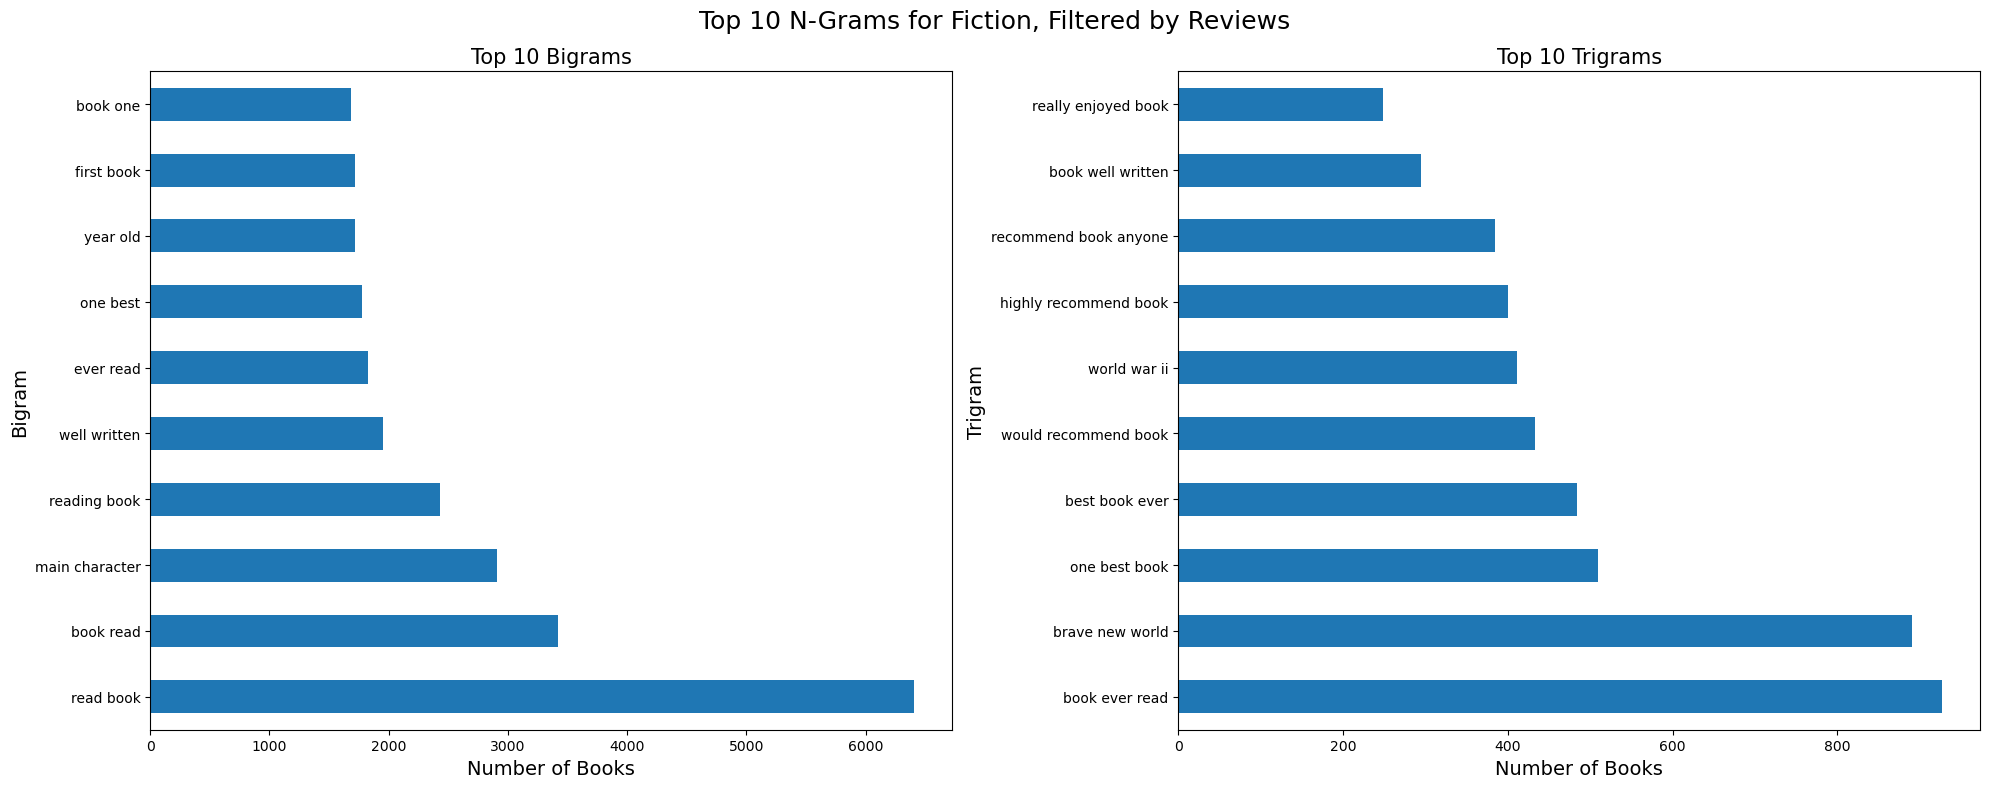

In [22]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
fig.suptitle('Top 10 N-Grams for Fiction, Filtered by Reviews', fontsize = 18)

fic_rev_bigrams = cv_bigram_fic_rev.sum().sort_values(ascending = False).head(10).plot(kind = 'barh', ax=ax[0])
fic_rev_trigrams = cv_trigram_fic_rev.sum().sort_values(ascending = False).head(10).plot(kind = 'barh', ax=ax[1])

fic_rev_bigrams.set_title('Top 10 Bigrams', fontsize = 15)
fic_rev_trigrams.set_title('Top 10 Trigrams', fontsize = 15)

fic_rev_bigrams.set_xlabel('Number of Books', fontsize = 14)
fic_rev_trigrams.set_xlabel('Number of Books', fontsize = 14)

fic_rev_bigrams.set_ylabel('Bigram', fontsize = 14)
fic_rev_trigrams.set_ylabel('Trigram', fontsize = 14)

plt.subplots_adjust(wspace=0.4);

plt.tight_layout()
plt.savefig('./graphs/fiction_rev_ngrams.png')

### Bigrams and Trigrams for Juvenile Fiction Dataset

In [23]:
bigram_jvf_desc = bigram_cvec.fit_transform(jvf_df['description'])
cv_bigram_jvf_desc = pd.DataFrame(bigram_jvf_desc.todense(), columns = bigram_cvec.get_feature_names_out())

trigram_jvf_desc  = trigram_cvec.fit_transform(jvf_df['description'])
cv_trigram_jvf_desc = pd.DataFrame(trigram_jvf_desc.todense(), columns = trigram_cvec.get_feature_names_out())

In [24]:
bigram_jvf_rev = bigram_cvec.fit_transform(jvf_df['review/text'])
cv_bigram_jvf_rev = pd.DataFrame(bigram_jvf_rev.todense(), columns = bigram_cvec.get_feature_names_out())

trigram_jvf_rev  = trigram_cvec.fit_transform(jvf_df['review/text'])
cv_trigram_jvf_rev = pd.DataFrame(trigram_jvf_rev.todense(), columns = trigram_cvec.get_feature_names_out())

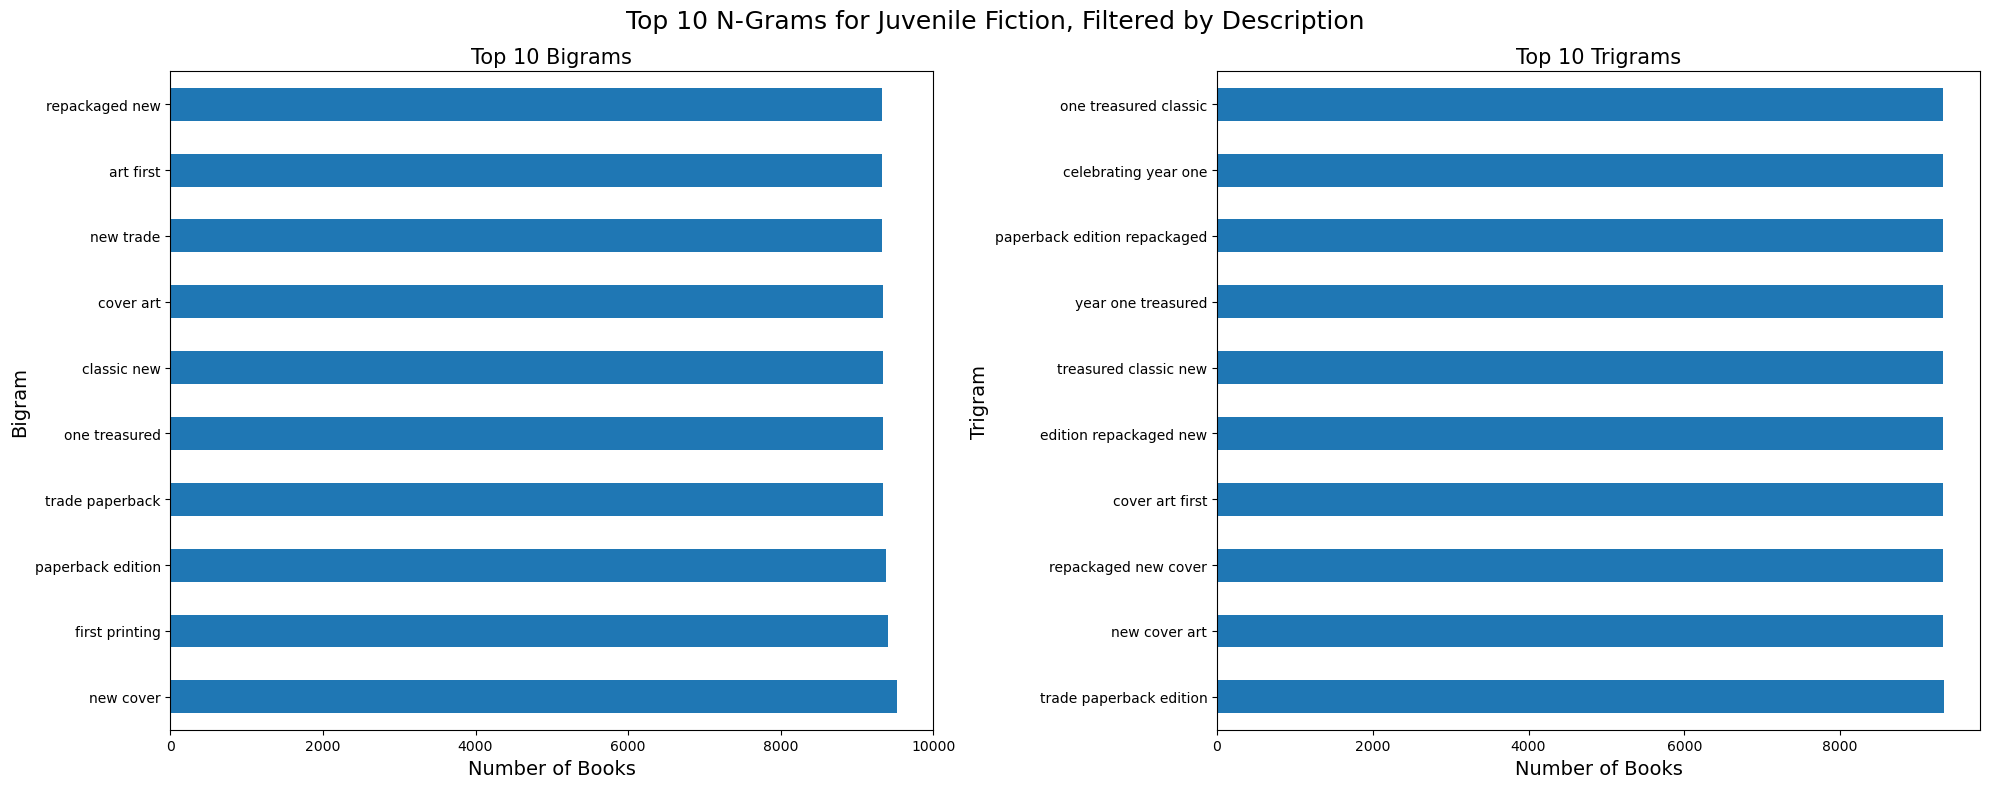

In [25]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
fig.suptitle('Top 10 N-Grams for Juvenile Fiction, Filtered by Description', fontsize = 18)

jvf_desc_bigrams = cv_bigram_jvf_desc.sum().sort_values(ascending = False).head(10).plot(kind = 'barh', ax=ax[0])
jvf_desc_trigrams = cv_trigram_jvf_desc.sum().sort_values(ascending = False).head(10).plot(kind = 'barh', ax=ax[1])

jvf_desc_bigrams.set_title('Top 10 Bigrams', fontsize = 15)
jvf_desc_trigrams.set_title('Top 10 Trigrams', fontsize = 15)

jvf_desc_bigrams.set_xlabel('Number of Books', fontsize = 14)
jvf_desc_trigrams.set_xlabel('Number of Books', fontsize = 14)

jvf_desc_bigrams.set_ylabel('Bigram', fontsize = 14)
jvf_desc_trigrams.set_ylabel('Trigram', fontsize = 14)

plt.subplots_adjust(wspace=0.4);

plt.tight_layout()
plt.savefig('./graphs/jvf_desc_ngrams.png')

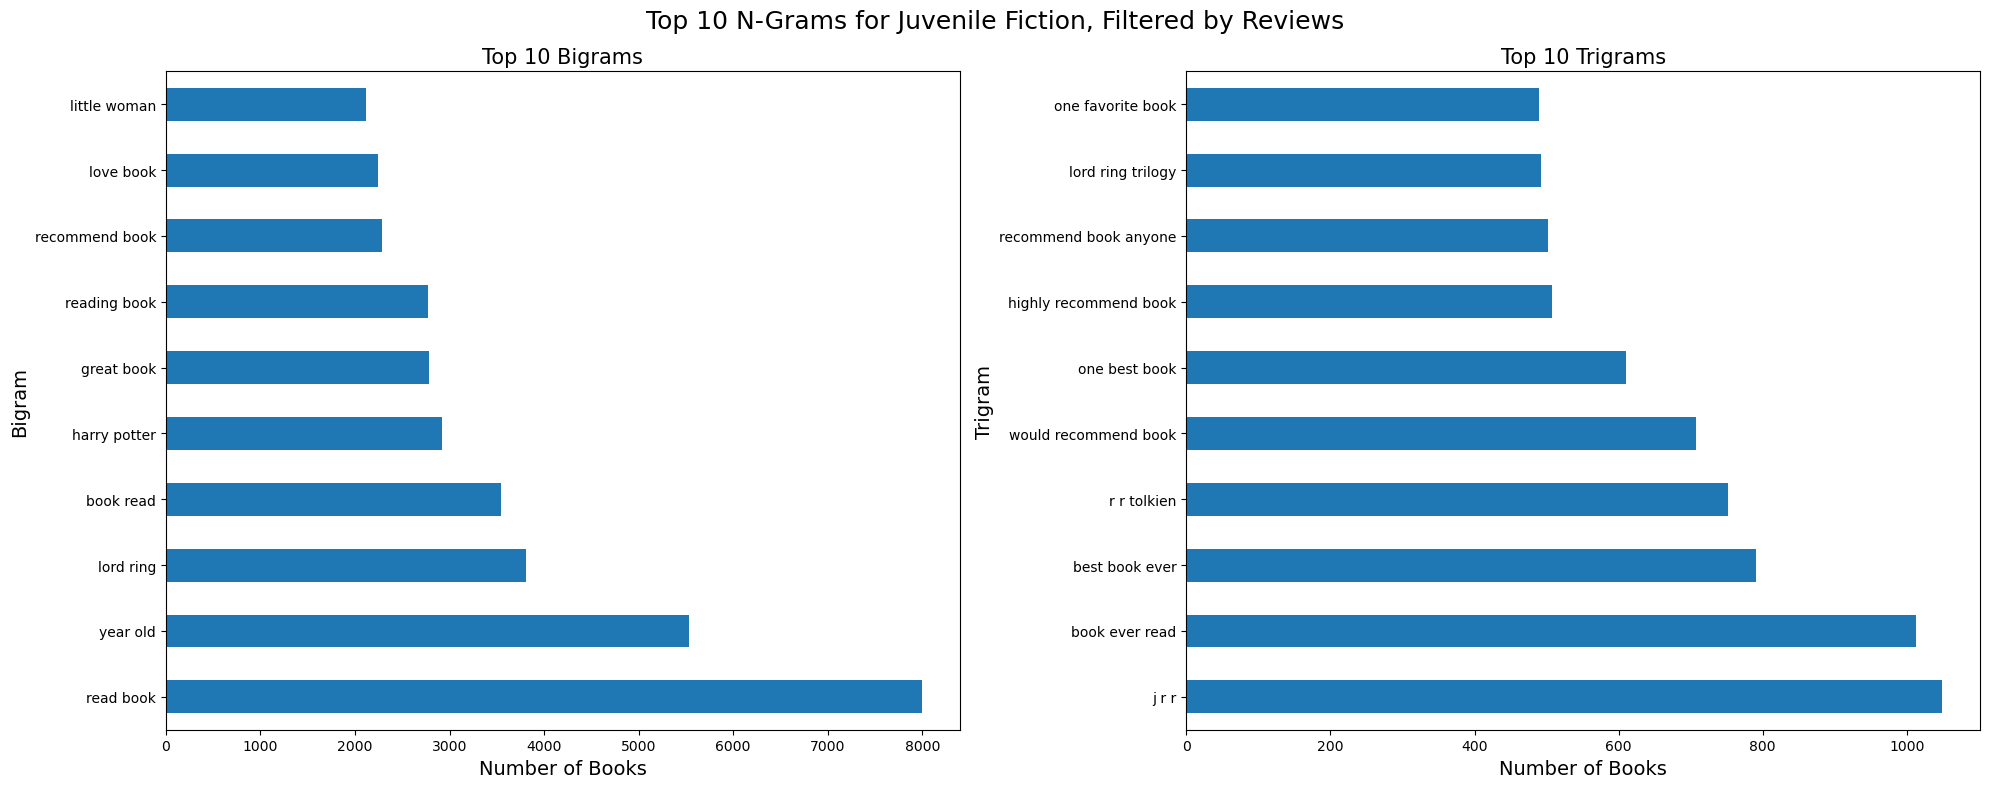

In [26]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
fig.suptitle('Top 10 N-Grams for Juvenile Fiction, Filtered by Reviews', fontsize = 18)

jvf_rev_bigrams = cv_bigram_jvf_rev.sum().sort_values(ascending = False).head(10).plot(kind = 'barh', ax=ax[0])
jvf_rev_trigrams = cv_trigram_jvf_rev.sum().sort_values(ascending = False).head(10).plot(kind = 'barh', ax=ax[1])

jvf_rev_bigrams.set_title('Top 10 Bigrams', fontsize = 15)
jvf_rev_trigrams.set_title('Top 10 Trigrams', fontsize = 15)

jvf_rev_bigrams.set_xlabel('Number of Books', fontsize = 14)
jvf_rev_trigrams.set_xlabel('Number of Books', fontsize = 14)

jvf_rev_bigrams.set_ylabel('Bigram', fontsize = 14)
jvf_rev_trigrams.set_ylabel('Trigram', fontsize = 14)

plt.subplots_adjust(wspace=0.4);

plt.tight_layout()
plt.savefig('./graphs/jvf_rev_ngrams.png')

### Bigrams and Trigrams for Biography & Autobiography Dataset

In [27]:
bigram_bio_desc = bigram_cvec.fit_transform(bio_df['description'])
cv_bigram_bio_desc = pd.DataFrame(bigram_bio_desc.todense(), columns = bigram_cvec.get_feature_names_out())

trigram_bio_desc  = trigram_cvec.fit_transform(bio_df['description'])
cv_trigram_bio_desc = pd.DataFrame(trigram_bio_desc.todense(), columns = trigram_cvec.get_feature_names_out())

In [28]:
bigram_bio_rev = bigram_cvec.fit_transform(bio_df['review/text'])
cv_bigram_bio_rev = pd.DataFrame(bigram_bio_rev.todense(), columns = bigram_cvec.get_feature_names_out())

trigram_bio_rev  = trigram_cvec.fit_transform(bio_df['review/text'])
cv_trigram_bio_rev = pd.DataFrame(trigram_bio_rev.todense(), columns = trigram_cvec.get_feature_names_out())

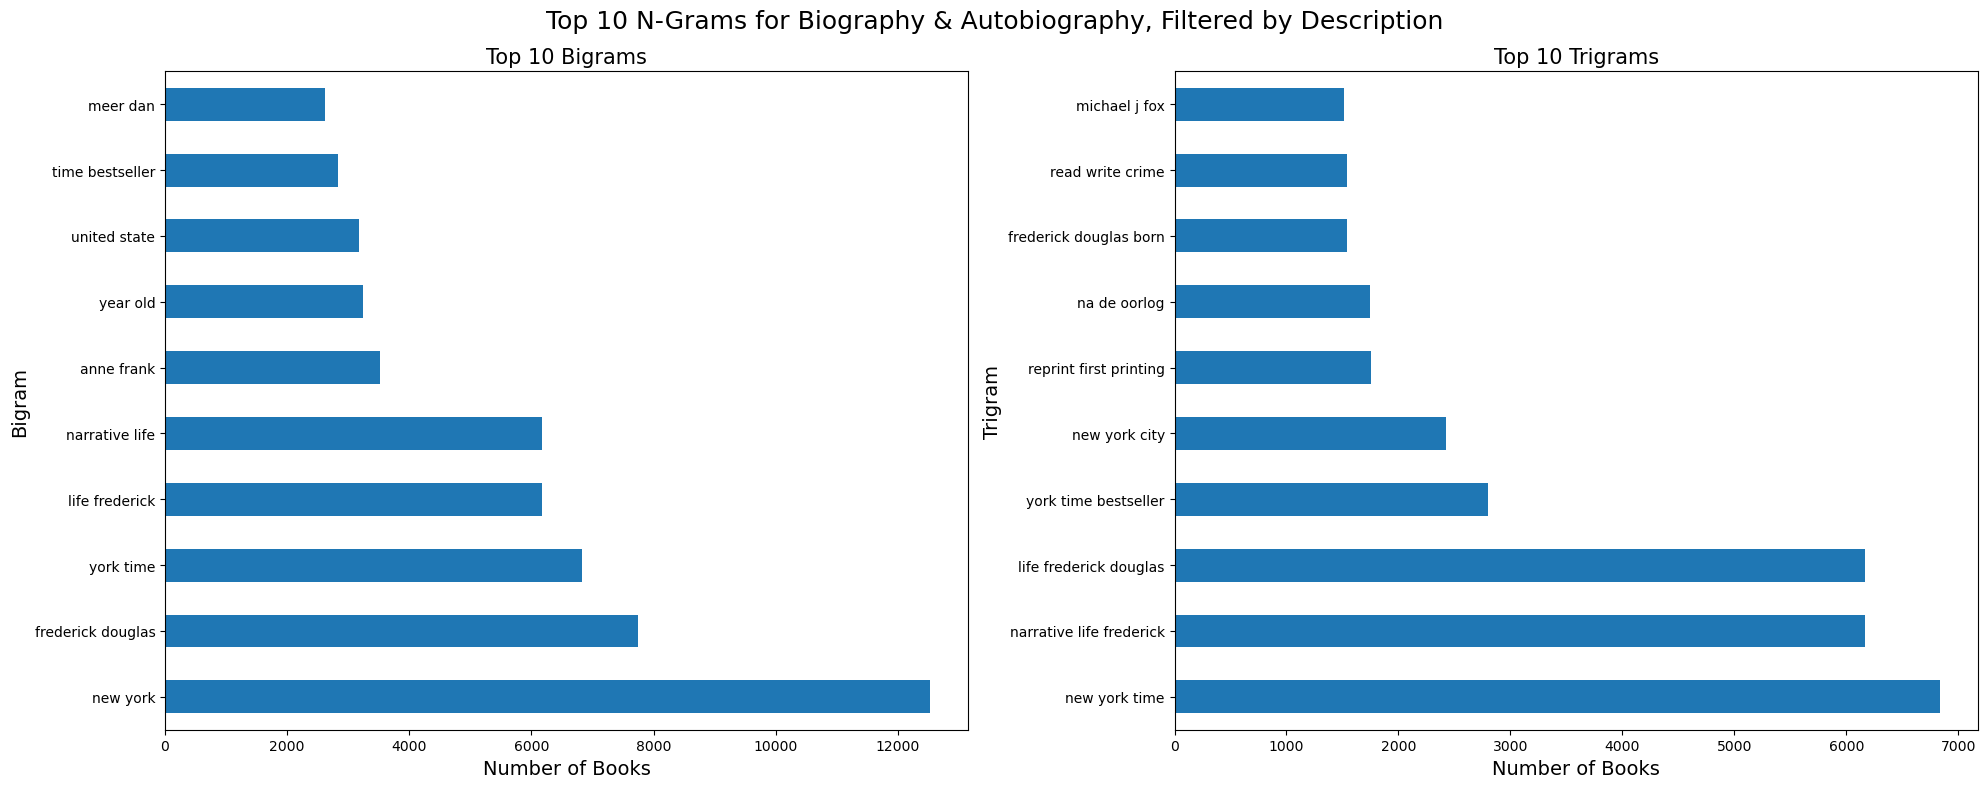

In [29]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
fig.suptitle('Top 10 N-Grams for Biography & Autobiography, Filtered by Description', fontsize = 18)

bio_desc_bigrams = cv_bigram_bio_desc.sum().sort_values(ascending = False).head(10).plot(kind = 'barh', ax=ax[0])
bio_desc_trigrams = cv_trigram_bio_desc.sum().sort_values(ascending = False).head(10).plot(kind = 'barh', ax=ax[1])

bio_desc_bigrams.set_title('Top 10 Bigrams', fontsize = 15)
bio_desc_trigrams.set_title('Top 10 Trigrams', fontsize = 15)

bio_desc_bigrams.set_xlabel('Number of Books', fontsize = 14)
bio_desc_trigrams.set_xlabel('Number of Books', fontsize = 14)

bio_desc_bigrams.set_ylabel('Bigram', fontsize = 14)
bio_desc_trigrams.set_ylabel('Trigram', fontsize = 14)

plt.subplots_adjust(wspace=0.4);

plt.tight_layout()
plt.savefig('./graphs/bio_desc_ngrams.png')

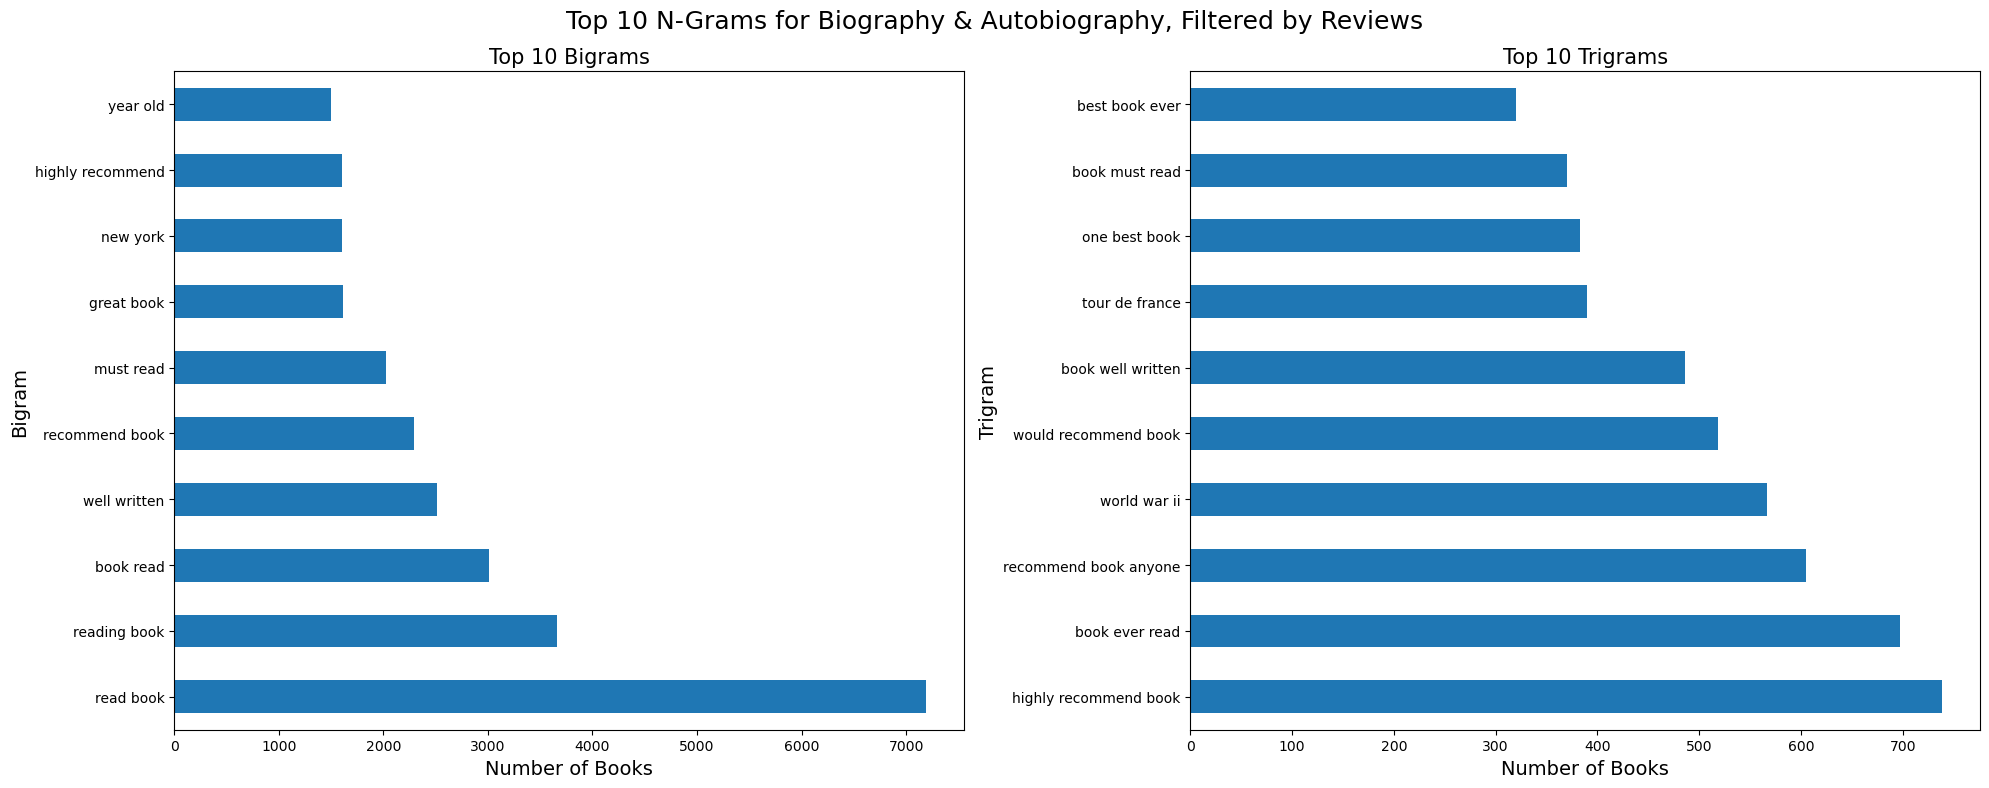

In [30]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
fig.suptitle('Top 10 N-Grams for Biography & Autobiography, Filtered by Reviews', fontsize = 18)

bio_rev_bigrams = cv_bigram_bio_rev.sum().sort_values(ascending = False).head(10).plot(kind = 'barh', ax=ax[0])
bio_rev_trigrams = cv_trigram_bio_rev.sum().sort_values(ascending = False).head(10).plot(kind = 'barh', ax=ax[1])

bio_rev_bigrams.set_title('Top 10 Bigrams', fontsize = 15)
bio_rev_trigrams.set_title('Top 10 Trigrams', fontsize = 15)

bio_rev_bigrams.set_xlabel('Number of Books', fontsize = 14)
bio_rev_trigrams.set_xlabel('Number of Books', fontsize = 14)

bio_rev_bigrams.set_ylabel('Bigram', fontsize = 14)
bio_rev_trigrams.set_ylabel('Trigram', fontsize = 14)

plt.subplots_adjust(wspace=0.4);

plt.tight_layout()
plt.savefig('./graphs/bio_rev_ngrams.png')

## Word Clouds

In [17]:
#pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 2.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In this section, we evaluate the words that appeared the most in our datasets. This enables us to see if there are some bias where certain words overpower the 'description' which may impact our models. If you look at all three word clouds, some words that stand out include 'New York', 'world', 'one', and 'Times'. I believe this aspect shows most descriptions begin with 'New York. Times #1 Bestseller' etc. For future improvements, I believe certain phrases describing a book should be removed so that users can use the content of the book to get their recommendations.

[WordCloud Pandas Source](https://thecleverprogrammer.com/2021/11/11/word-cloud-from-a-pandas-dataframe-in-python/)

Note: Word Clouds will not save png properly.

In [30]:
fiction_text = " ".join(i for i in fiction_df['description'])

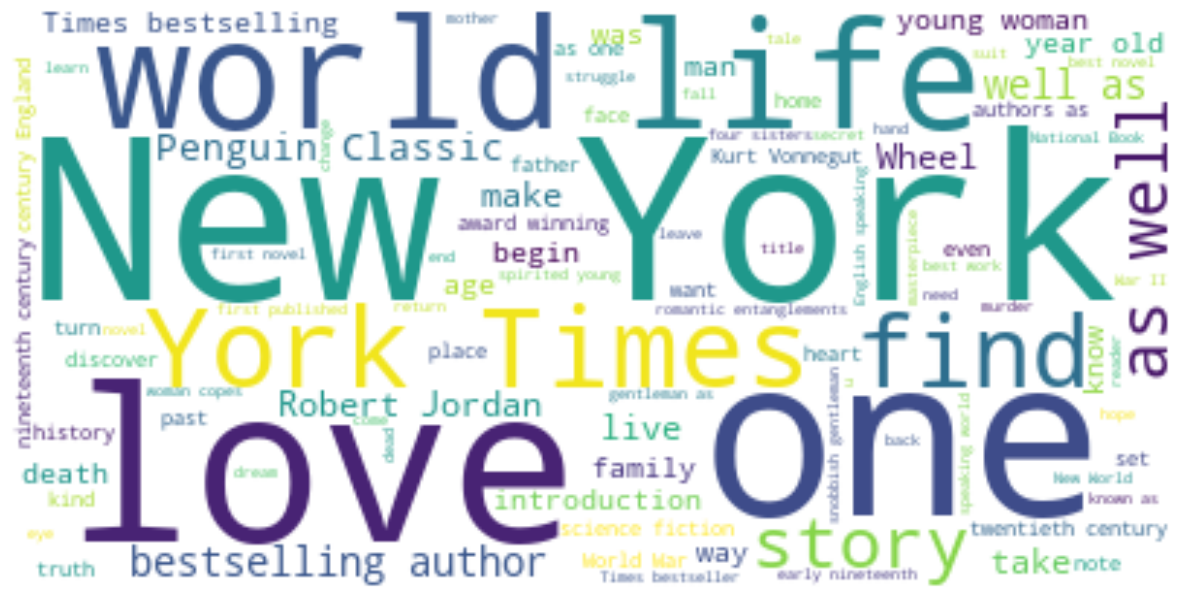

<Figure size 640x480 with 0 Axes>

In [31]:
fiction_wc = WordCloud(stopwords = lem_stopwords, background_color = "rgba(255, 255, 255, 0)").generate(fiction_text)

plt.figure(figsize=(15, 10))
plt.imshow(fiction_wc, interpolation='bilinear')
plt.axis("off")
plt.show();

plt.tight_layout()
plt.savefig('./graphs/fiction_wc.png')

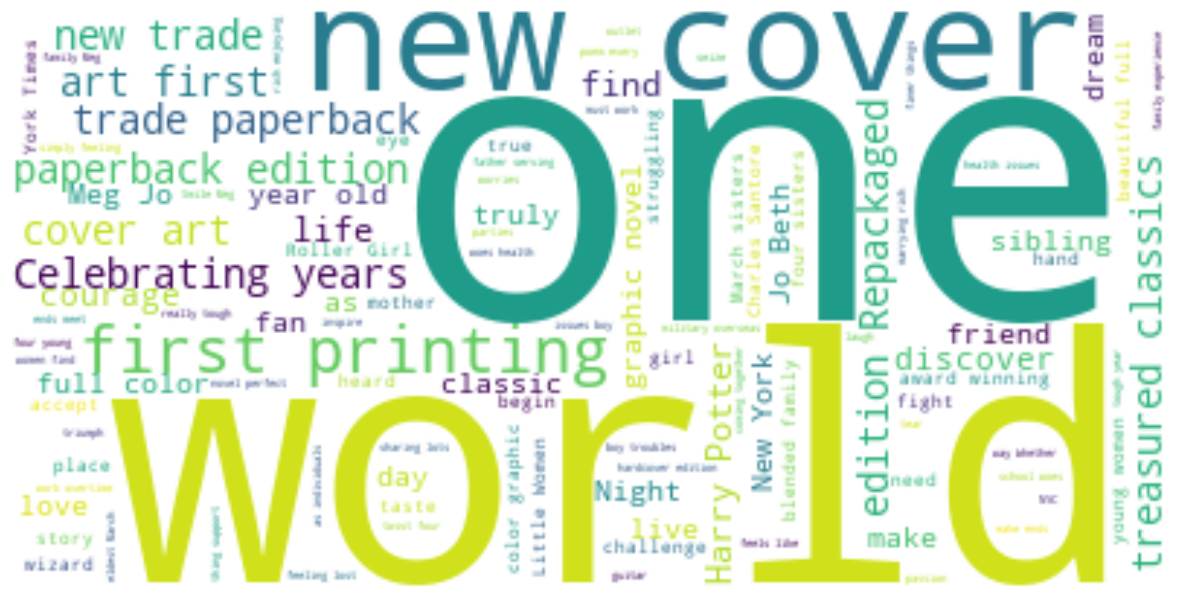

<Figure size 640x480 with 0 Axes>

In [32]:
jvf_text = " ".join(i for i in jvf_df['description'])

jvf_wc = WordCloud(stopwords = lem_stopwords, background_color = "rgba(255, 255, 255, 0)").generate(jvf_text)

plt.figure(figsize=(15, 10))
plt.imshow(jvf_wc, interpolation='bilinear')
plt.axis("off")
plt.show();

plt.tight_layout()
plt.savefig('./graphs/jvf_wc.png')

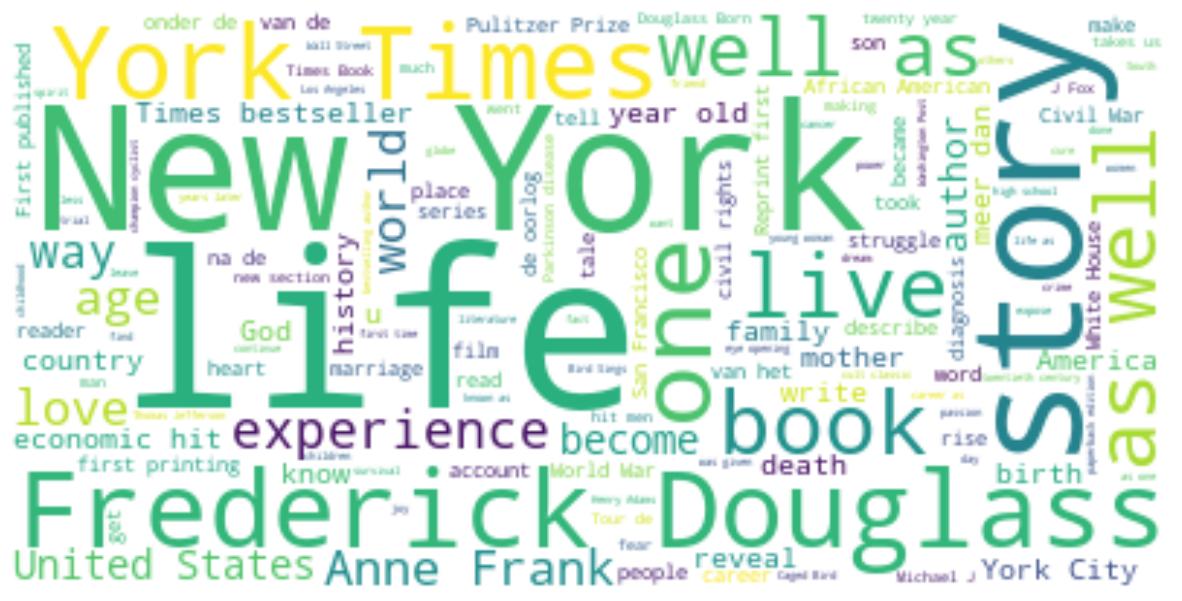

<Figure size 640x480 with 0 Axes>

In [34]:
bio_text = " ".join(i for i in bio_df['description'])

bio_wc = WordCloud(stopwords = lem_stopwords, background_color = "rgba(255, 255, 255, 0)").generate(bio_text)

plt.figure(figsize=(15, 10))
plt.imshow(bio_wc, interpolation='bilinear')
plt.axis("off")
plt.show()

plt.tight_layout()
plt.savefig('./graphs/bio_wc.png')

### Sentiment Analysis

In this section, we explore the initial responses to the books that we have in our datasets. The SentimentIntensityAnalayzer uses a pre-trained model from NLTK to provide a sentiment score. In the function, we call for polarity_scores which returns a dictionary of sentiment scores and then an overall scor. We classify whether the reviews are positive, negative or neutral.

In the bar charts, we see that across all datasets, the reviews were positive and in a similar range to one another. I was even skeptical and printed out the number of books within each sentiment category to see if my code ran correctly.

In [38]:
sent = SentimentIntensityAnalyzer()
def sentiment_score(text):
    sentiment_score = sent.polarity_scores(text)
    sentiment_value = ''
    
    if sentiment_score['compound'] > 0:
        sentiment_value = 'positive'
    elif sentiment_score['compound'] < 0:
        sentiment_value = 'negative' 
    elif sentiment_score['compound'] == 0:
        sentiment_value = 'neutral'  
 
    return sentiment_value

In [44]:
def sentiment_score(text):
    sentiment_scores = sent.polarity_scores(text)
    sentiment_value = sentiment_scores['compound']
    
    return sentiment_value

In [45]:
fiction_df['review_sentiment'] = fiction_df['review/text'].apply(sentiment_score)
jvf_df['review_sentiment'] = jvf_df['review/text'].apply(sentiment_score)
bio_df['review_sentiment'] = bio_df['review/text'].apply(sentiment_score)

In [46]:
fiction_counts = fiction_df['review_sentiment'].value_counts()
jvf_counts = jvf_df['review_sentiment'].value_counts()
bio_counts = bio_df['review_sentiment'].value_counts()

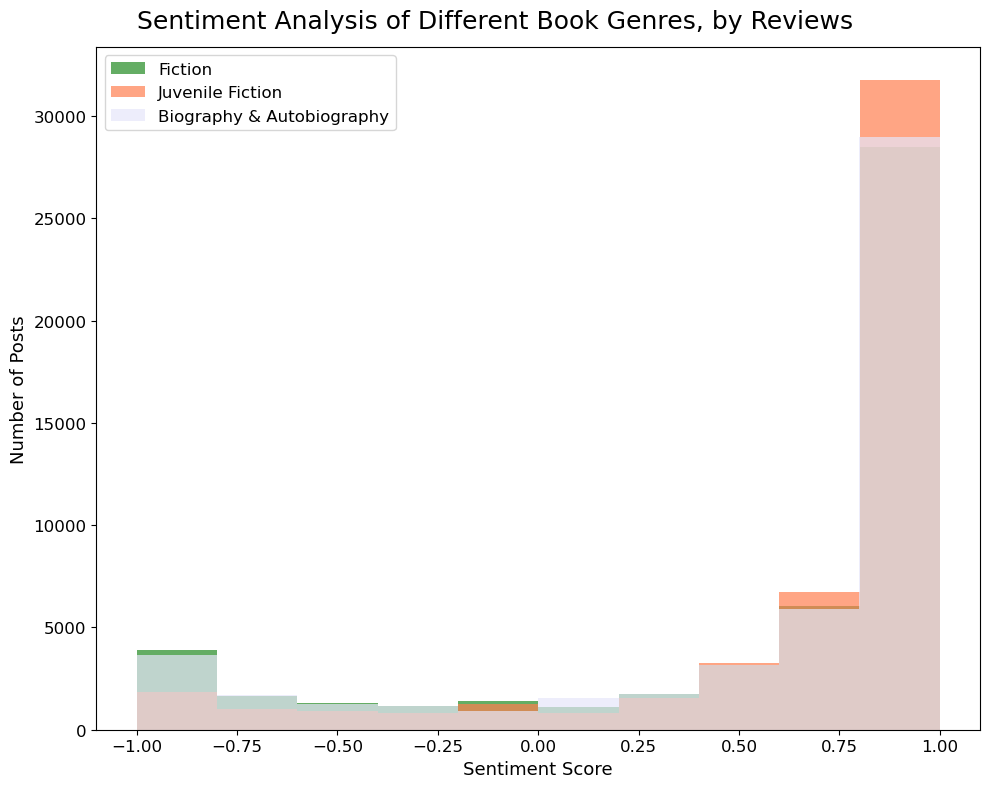

In [58]:
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle('Sentiment Analysis of Different Book Genres, by Reviews', fontsize=18)

plt.hist(fiction_df['review_sentiment'], bins=10, color='forestgreen', label='Fiction', alpha=0.7)
plt.hist(jvf_df['review_sentiment'], bins=10, color='coral', label='Juvenile Fiction', alpha=0.7)
plt.hist(bio_df['review_sentiment'], bins=10, color='lavender', label='Biography & Autobiography', alpha=0.7)

plt.xlabel('Sentiment Score', size=13)
plt.ylabel('Number of Posts', size=13)
plt.tick_params(axis='both', labelsize=12)
plt.legend(loc='upper left', fontsize=12);

plt.tight_layout()
plt.savefig('./graphs/compound_scores.png')

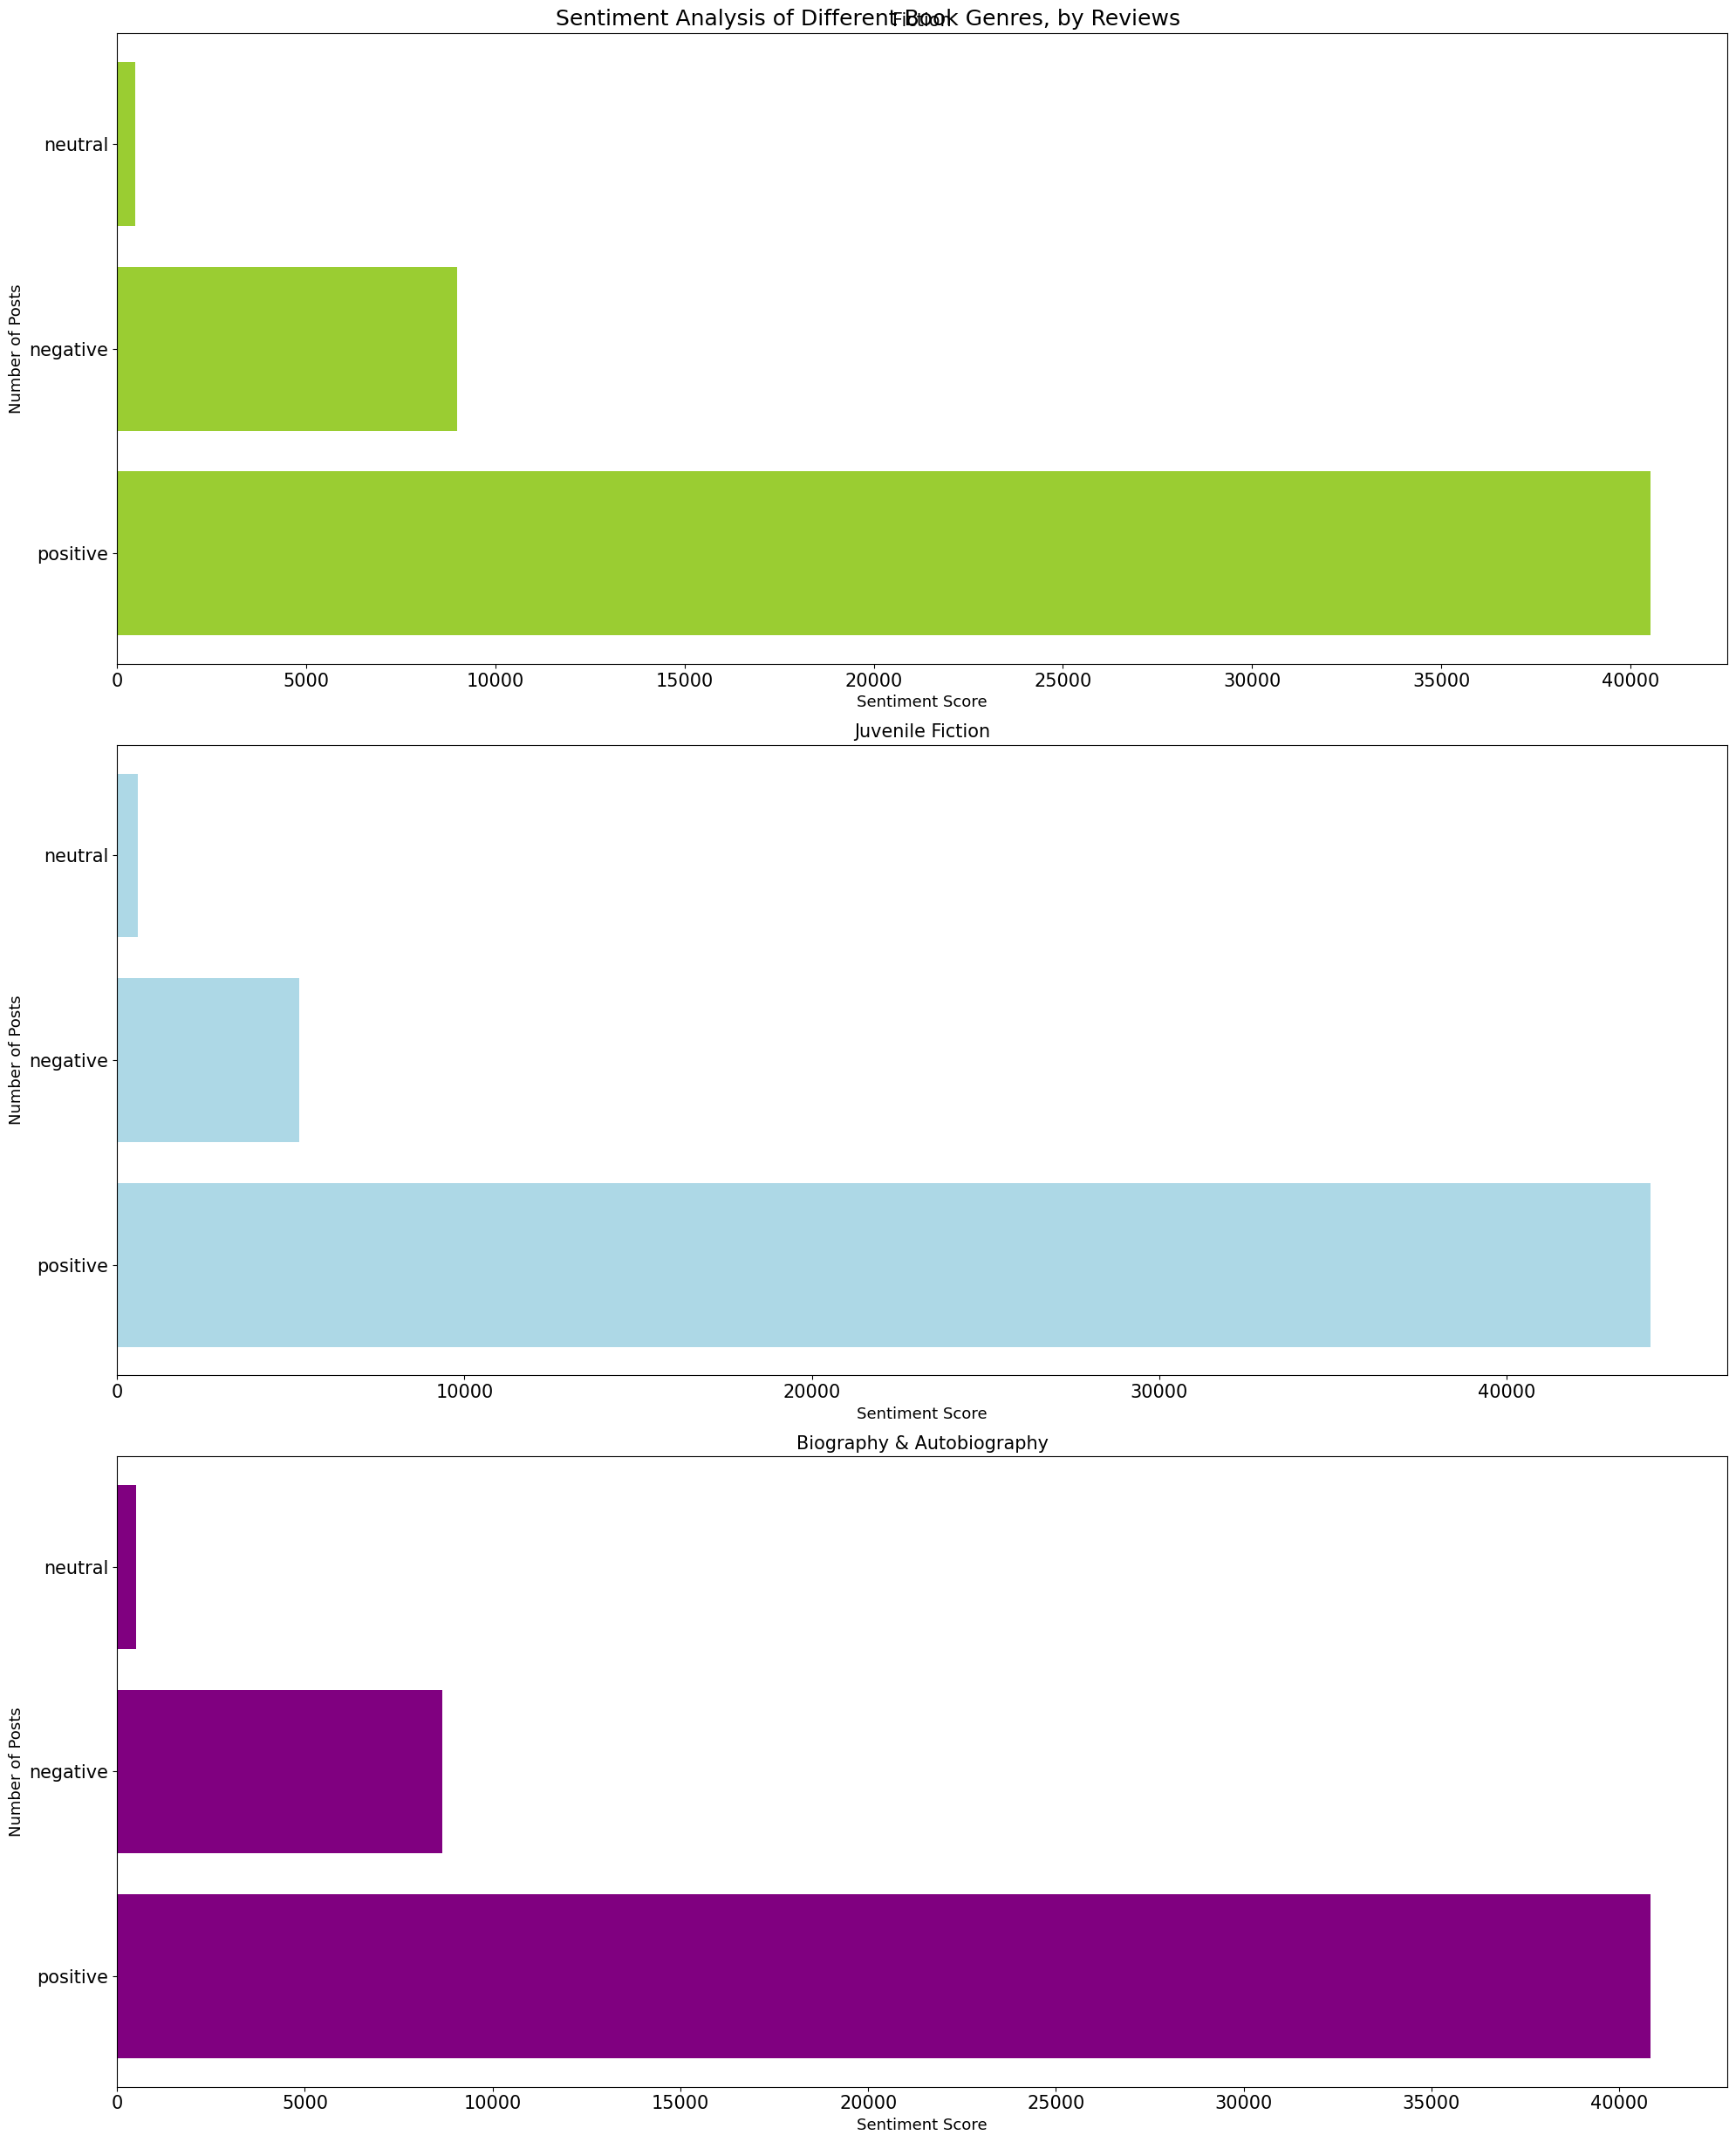

In [37]:
fig, ax = plt.subplots(3, 1, figsize=(20, 25))
fig.suptitle('Sentiment Analysis of Different Book Genres, by Reviews', fontsize=18)

ax[0].barh(fiction_counts.index, fiction_counts.values, color='yellowgreen')
ax[0].set_title('Fiction', size=15)
ax[0].set_xlabel('Sentiment Score', size=13)
ax[0].set_ylabel('Number of Posts', size=13)
ax[0].tick_params(axis='both', labelsize=15)

ax[1].barh(jvf_counts.index, jvf_counts.values, color='lightblue')
ax[1].set_title('Juvenile Fiction', size=15)
ax[1].set_xlabel('Sentiment Score', size=13)
ax[1].set_ylabel('Number of Posts', size=13)
ax[1].tick_params(axis='both', labelsize=15)

ax[2].barh(bio_counts.index, bio_counts.values, color='purple')
ax[2].set_title('Biography & Autobiography', size=15)
ax[2].set_xlabel('Sentiment Score', size=13)
ax[2].set_ylabel('Number of Posts', size=13)
ax[2].tick_params(axis='both', labelsize=15)

plt.tight_layout()
plt.savefig('./graphs/sentiment_score.png')

In [21]:
print(f'Fiction')
print("---")
print(fiction_counts)
print("---\n")

print(f'Juvenile Fiction')
print("---")
print(jvf_counts)
print("---\n")

print(f'Biography & Autobiography')
print("---")
print(bio_counts)

Fiction
---
positive    40534
negative     8995
neutral       471
Name: review_sentiment, dtype: int64
---

Juvenile Fiction
---
positive    44143
negative     5253
neutral       604
Name: review_sentiment, dtype: int64
---

Biography & Autobiography
---
positive    40834
negative     8663
neutral       503
Name: review_sentiment, dtype: int64


### 10 Most Occurring Titles, by Dataset

In the barchart below, we'll see the 10 authors that appear the most in our dataset. We can also make the assumption that if the authors occur most-often, then their books will most likely follow a similar pattern. For example, Jane Austen appeared the most and is the author that wrote Pride and Prejudice.

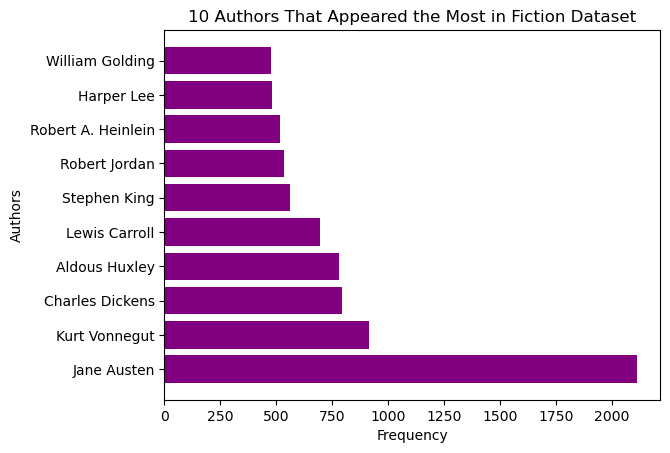

In [22]:
fic_most_common = fiction_df['authors'].value_counts().head(10)

plt.barh(fic_most_common.index, fic_most_common.values, color = 'purple')
plt.title('10 Authors That Appeared the Most in Fiction Dataset')
plt.xlabel('Frequency')
plt.ylabel('Authors')

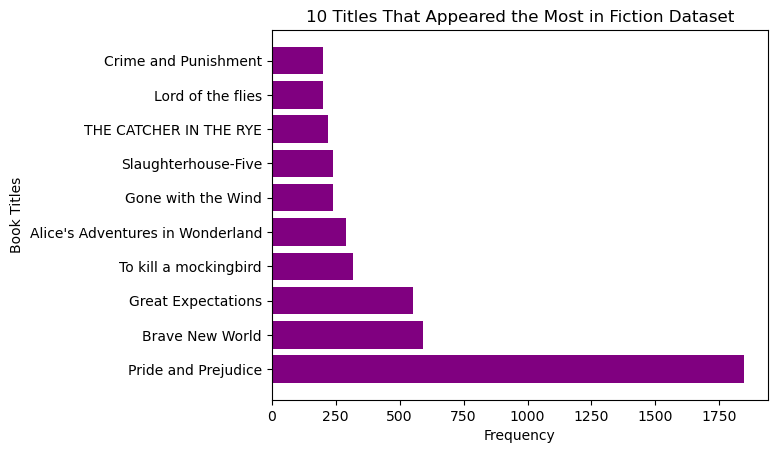

In [26]:
fic_most_common = fiction_df['Title'].value_counts().head(10)

plt.barh(fic_most_common.index, fic_most_common.values, color = 'purple')
plt.title('10 Titles That Appeared the Most in Fiction Dataset')
plt.xlabel('Frequency')
plt.ylabel('Book Titles');

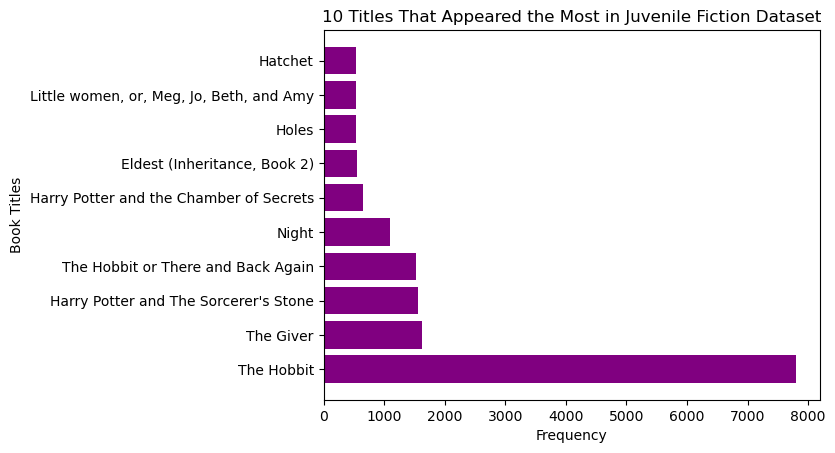

In [27]:
jvf_most_common = jvf_df['Title'].value_counts().head(10)

plt.barh(jvf_most_common.index, jvf_most_common.values, color = 'purple')
plt.title('10 Titles That Appeared the Most in Juvenile Fiction Dataset')
plt.xlabel('Frequency')
plt.ylabel('Book Titles');

Note: We didn't take this into consideration, but there are books that are the same, but classified differently because of how they're formatted. You can see an example with 'Anne Frank: The Diary of a Young Girl' and 'Anne Frank The Diary of a Young Girl' being treated separately. For future users, they should preprocess the dataset further to remove these

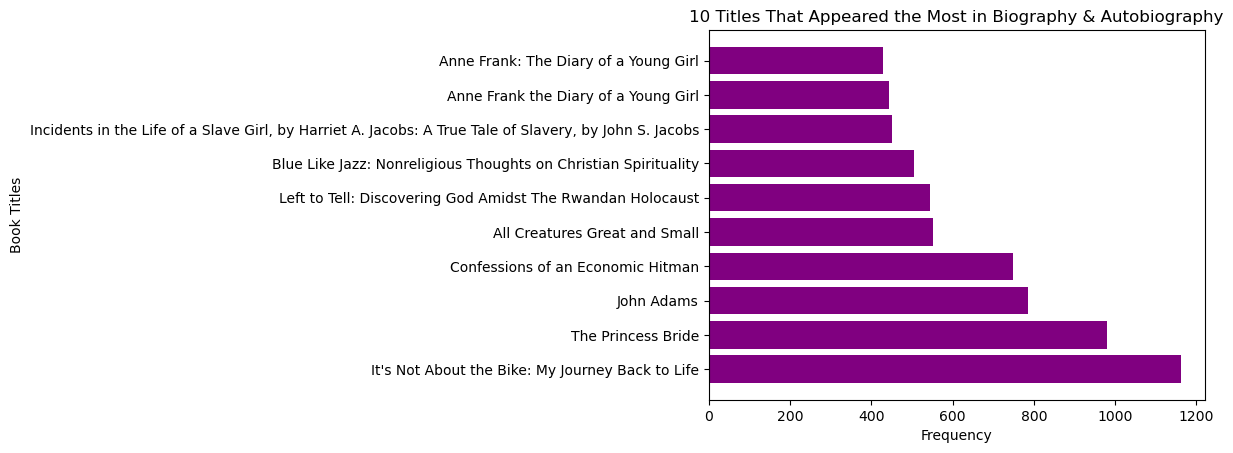

In [28]:
bio_most_common = bio_df['Title'].value_counts().head(10)

plt.barh(bio_most_common.index, bio_most_common.values, color = 'purple')
plt.title('10 Titles That Appeared the Most in Biography & Autobiography')
plt.xlabel('Frequency')
plt.ylabel('Book Titles');